In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
!hdfs dfsadmin -fs hdfs://nn:9000/ -report

Configured Capacity: 25821052928 (24.05 GB)
Present Capacity: 11555901440 (10.76 GB)
DFS Remaining: 11357777920 (10.58 GB)
DFS Used: 198123520 (188.95 MB)
DFS Used%: 1.71%
Replicated Blocks:
	Under replicated blocks: 16
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 16
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 192.168.16.6:9866 (project-5-asian_cheese_p5-dn-1.project-5-asian_cheese_p5_default)
Hostname: df5aa1014e59
Decommission Status : Normal
Configured Capacity: 25821052928 (24.05 GB)
DFS Used: 198123520 (188.95 MB)
Non DFS Used: 14248374272 (13.27 GB)
DFS Remaining: 11357777920 (10.58 GB)
DFS Used

In [3]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/


In [4]:

spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/06 00:47:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#q1

banks_df = (spark.read.format("csv")
      .option("header", True)  
      .option("inferSchema", True) 
      .load("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv"))  

banks_rdd = banks_df.rdd

banks_rdd_filter = banks_rdd.filter(lambda row: "The" in row.respondent_name and "National" in row.respondent_name)

bank_count = banks_rdd_filter.count()

bank_count



106

In [6]:
#q2

banks_df_filter = banks_df.filter(banks_df.respondent_name.contains("The") & banks_df.respondent_name.contains("National"))

bank_count = banks_df_filter.count()

bank_count


106

In [7]:
#q3
banks_df.write.saveAsTable("banks", mode="overwrite")

bankcount_df = spark.sql("""
SELECT COUNT(*) as bank_count
FROM banks
WHERE respondent_name LIKE '%The%' AND respondent_name LIKE '%National%'
""")
bank_count = bankcount_df.collect()[0]['bank_count']
bank_count


24/04/06 00:48:25 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/06 00:48:25 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/06 00:48:29 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/06 00:48:29 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@192.168.16.5
24/04/06 00:48:31 WARN HadoopFSUtils: The directory hdfs://nn:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
24/04/06 00:48:31 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/04/06 00:48:31 WARN FileUtils: File does not exist: hdfs://nn:9000/user/hive/warehouse/banks; Force to delete it.
24/04/06 00:48:31 ERROR FileUtils: Failed to delete hdfs://nn:9000/user/hive/warehouse/banks
24/04/06 00:48:34 WARN SessionSta

106

In [8]:
#q4
loans_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("hdfs://nn:9000/hdma-wi-2021.csv")

loans_df.write.bucketBy(8, "county_code") \
    .saveAsTable("loans", format="parquet", mode="overwrite")

my_list = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", 
           "loan_type", "loan_purpose", "preapproval", "property_type"]

for i in my_list:
    df = spark.read.option("header", "true").option("inferSchema", "true").csv(f"hdfs://nn:9000/{i}.csv")
    df.createOrReplaceTempView(i)

tables_warehouse = spark.sql("SHOW TABLES")

table_list_collect = tables_warehouse.collect()
dict_4 = {row.tableName: row.isTemporary for row in table_list_collect}
dict_4


24/04/06 00:48:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [9]:
# !hdfs dfs -ls hdfs://nn:9000/user/hive/warehouse/loans


In [10]:
#q5
loan_applications_count = spark.sql("""
SELECT COUNT(*)
FROM loans
INNER JOIN banks ON loans.lei = banks.lei_2020
WHERE banks.respondent_name = 'First National Bank'
""").collect()[0][0]

loan_applications_count



6

In [11]:
#q6
# banks_df.explain("formatted") has output 5
# loans_df.explain("formatted") has output 99
# 1) bank table is sent to every executor via a BroadcastExchange
# 2) It does not involve HashAggregate because we didn't use aggregate function such as GROUP BY

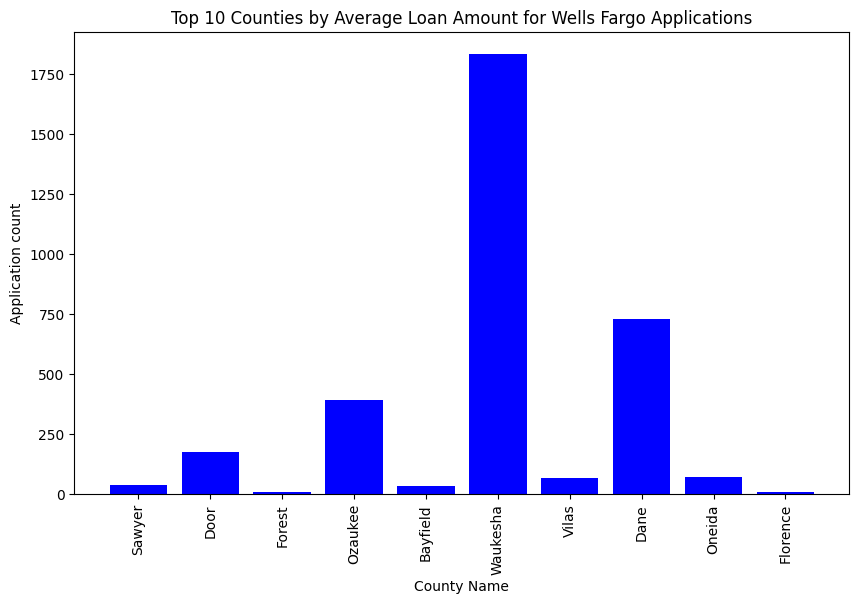

{'Sawyer': 38,
 'Door': 174,
 'Forest': 7,
 'Ozaukee': 389,
 'Bayfield': 33,
 'Waukesha': 1832,
 'Vilas': 68,
 'Dane': 729,
 'Oneida': 70,
 'Florence': 8}

In [12]:
#q7
top_counties_qry = """
SELECT counties.name AS county_name, 
       AVG(loans.loan_amount) AS avg_loan_amount,
       COUNT(*) AS application_count
FROM loans
INNER JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
INNER JOIN banks ON loans.lei = banks.lei_2020
WHERE banks.respondent_name LIKE '%Wells Fargo%'
GROUP BY counties.name
ORDER BY avg_loan_amount DESC
LIMIT 10
"""

top_counties = spark.sql(top_counties_qry) #Execute query
list_top_counties = top_counties.collect() #collecting results to python list

county_appli_dict = {row['county_name']: row['application_count'] for row in list_top_counties} #dict from the query results

counties = [row['county_name'] for row in list_top_counties] #data for plotting
application_count = [row['application_count'] for row in list_top_counties]

plt.figure(figsize = (10, 6))
plt.bar(counties, application_count, color = 'blue')
plt.xlabel('County Name')
plt.ylabel('Application count')
plt.title('Top 10 Counties by Average Loan Amount for Wells Fargo Applications')
plt.xticks(rotation = 90)
plt.show()

county_appli_dict


In [13]:
#q8
# df_group_by_county_code = spark.sql("SELECT county_code, AVG(loan_amount) FROM loans GROUP BY county_code")
# df_group_by_county_code.explain()
# df_group_by_lei = spark.sql("SELECT lei, AVG(loan_amount) FROM loans GROUP BY lei")
# df_group_by_lei.explain()
# For the `lei` GroupBy, because bucketing is not applied, significant network I/O is necessary to shuffle data for
# aggregation. In contrast, the `county_code` GroupBy benefits from bucketing, significantly reducing the amount of 
# data shuffled across the network for aggregation. However, while bucketing optimizes the operation by localizing data 
# and thus reducing network I/O, it does not entirely eliminate network I/O for aggregating partial results across 
# partitions or executors.


In [14]:
#q9

#adapted from https://www.w3schools.com/sql/sql_case.asp
#use the site for reference on how to use SQL CASE Expression
loans = spark.sql("""
     SELECT (CASE
         WHEN action_taken=1 THEN 1
         ELSE 0
         END)
     AS approval, income, interest_rate, loan_amount
     FROM loans
 """)

#adapted from https://datamadness.medium.com/casting-data-types-in-pyspark-f95d1326449b
#used the site for adapting the use of casting data type into a double
df = loans.select(col("loan_amount").cast("double").alias("loan_amount"), 
                  col("income").cast("double").alias("income"), 
                  col("interest_rate").cast("double").alias("interest_rate"), 
                  col("approval").cast("double").alias("approval"))

df = df.na.fill(0.0)
#df.show()

train, test = df.randomSplit([0.8, 0.2], seed=41)  #spliting 8:2
train.cache()

count = float(train.filter(col("approval") == 1).count()) #to doub
count


242868.0

In [15]:
#q10
assembler = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features") #in output columns
df_assem_trf = assembler.transform(df)

train, test = df_assem_trf.randomSplit([0.8, 0.2], seed=41) # feature col is included

randf = RandomForestClassifier(featuresCol="features", labelCol="approval", numTrees=10) # classifier
randf_model = randf.fit(train) #training

predictions = randf_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="approval", predictionCol="prediction", metricName="accuracy")

accu = evaluator.evaluate(predictions)
accu



0.8930753904206413